# Diagnosing Biased Inference with Divergences

PyMC3 port of [Michael Betancourt's post on ms-stan](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html). For detailed explanation of the underlying mechanism please check [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) and Betancourt's [excellent paper](https://arxiv.org/abs/1701.02434).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm 

%matplotlib inline

## A Centered Eight Schools Implementation  
$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\theta_{n} \sim \mathcal{N}(\mu, \tau)$$
$$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$$  

where $n \in \{1, \ldots, 8 \}$ and the $\{ y_{n}, \sigma_{n} \}$ are given as data. 

Stan model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
```

In [15]:
J = 8
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12],dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18],dtype=float)
# tau = 25.
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu',mu=0,sd=5)
    tau = pm.HalfCauchy('tau',beta=5)
    theta = pm.Normal('theta',mu=mu,sd=tau,shape = J)
    obs = pm.Normal('obs',mu=theta,sd=sigma,observed = y)

In [16]:
def report_trace(trace):
    pm.traceplot(trace,varnames=['tau_log_'])
    logtau  = trace['tau_log_']
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1,len(logtau))]
    plt.figure(figsize=(15,2))
    plt.plot(mlogtau)
    plt.axhline(0.7657852,color='k',alpha=.5)
    plt.ylim(0,2)
    plt.show()
    
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)
    
    theta_trace = trace['theta']
    theta0 = theta_trace[:,0]
    plt.figure(figsize=(10,6))
    plt.scatter(theta0[divergent==0],logtau[divergent==0],color='r')
    plt.scatter(theta0[divergent==1],logtau[divergent==1],color='g')
    plt.axis([-20,50,-6,4])
    plt.show()

#### A Dangerously-Short Markov Chain

Assigned NUTS to mu
Assigned NUTS to tau_log_
Assigned NUTS to theta
100%|██████████| 1200/1200 [00:01<00:00, 604.53it/s]


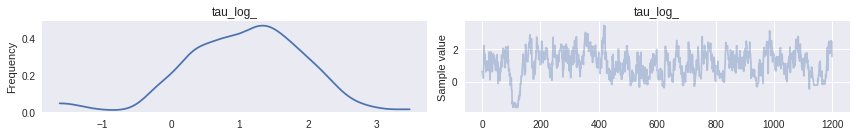

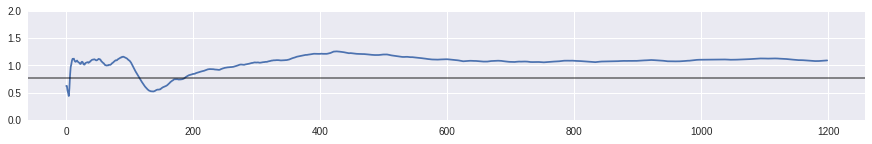

Number of Divergent 14
Percentage of Divergent 0.01167


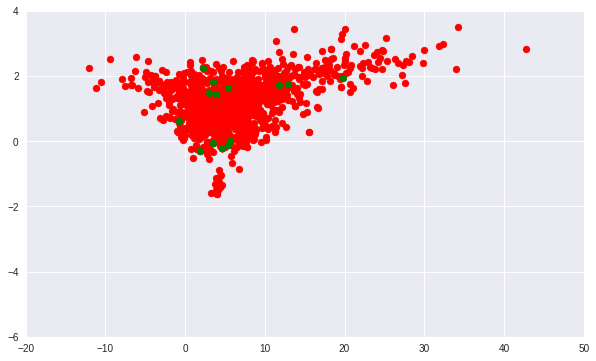

In [17]:
with Centered_eight:
    short_trace = pm.sample(1200, init=None, njobs=1, tune=500)
    
report_trace(short_trace)

#### A Safer, Longer Markov Chain

Assigned NUTS to mu
Assigned NUTS to tau_log_
Assigned NUTS to theta
100%|██████████| 10000/10000 [00:16<00:00, 593.48it/s]


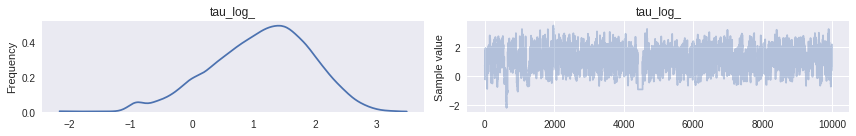

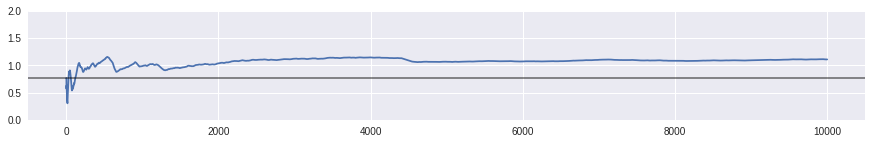

Number of Divergent 11
Percentage of Divergent 0.00110


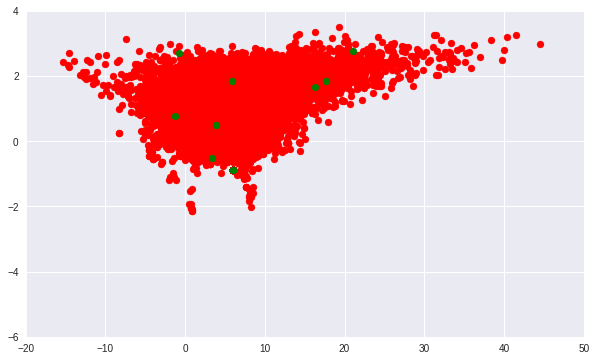

In [18]:
with Centered_eight:
    longer_trace = pm.sample(10000, init=None, njobs=1, tune=1000)
    
report_trace(longer_trace)

#### Adjusting Adaptation Routine

In [19]:
with Centered_eight:
    step = pm.NUTS(k=.85)
    fit_cp85 = pm.sample(10000, step=step, init=None, njobs=1, tune=1000)
with Centered_eight:
    step = pm.NUTS(k=.90)
    fit_cp90 = pm.sample(10000, step=step, init=None, njobs=1, tune=1000)
with Centered_eight:
    step = pm.NUTS(k=.95)
    fit_cp95 = pm.sample(10000, step=step, init=None, njobs=1, tune=1000)
with Centered_eight:
    step = pm.NUTS(k=.99)
    fit_cp99 = pm.sample(10000, step=step, init=None, njobs=1, tune=1000)

100%|██████████| 10000/10000 [00:13<00:00, 717.07it/s]


In [20]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                    fit_cp85['step_size'].mean(),
                    fit_cp90['step_size'].mean(),
                    fit_cp95['step_size'].mean(),
                    fit_cp99['step_size'].mean()],columns=['Step_size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                    fit_cp85['diverging'].sum(),
                    fit_cp90['diverging'].sum(),
                    fit_cp95['diverging'].sum(),
                    fit_cp99['diverging'].sum()])

In [21]:
df

,Step_size,Divergent
0,0.184593,11
1,0.231132,108
2,0.206688,40
3,0.205411,35
4,0.219485,21


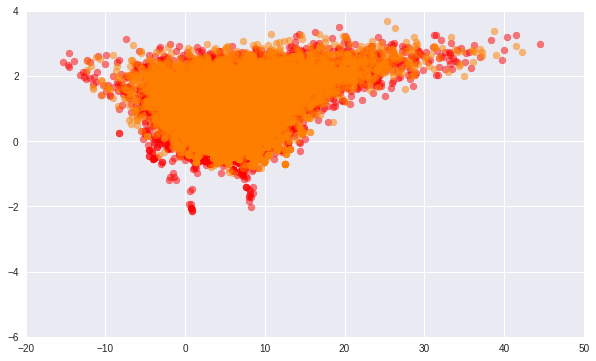

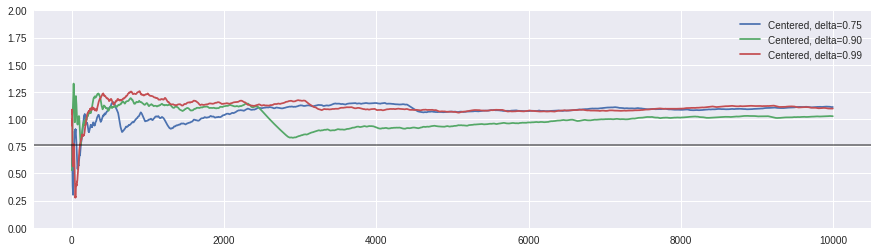

In [22]:
theta0 = longer_trace['theta'][:,0]
logtau0  = longer_trace['tau_log_']
divergent0 = longer_trace['diverging']

theta1 = fit_cp99['theta'][:,0]
logtau1  = fit_cp99['tau_log_']
divergent1 = fit_cp99['diverging']

plt.figure(figsize=(10,6))
plt.scatter(theta0[divergent0==0],logtau0[divergent0==0],color='r',alpha=.5)
plt.scatter(theta1[divergent1==0],logtau1[divergent1==0],color=[1,0.5,0],alpha=.5)
plt.axis([-20,50,-6,4])
plt.show()

logtau2  = fit_cp90['tau_log_']

plt.figure(figsize=(15,4))
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1,len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.75')
mlogtau2 = [np.mean(logtau2[:i]) for i in np.arange(1,len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90')
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1,len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99')
plt.axhline(0.7657852,color='k',alpha=.5)
plt.ylim(0,2)
plt.legend()
plt.show()

## A Non-Centered Eight Schools Implementation  
$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\tilde{\theta}_{n} \sim \mathcal{N}(0, 1)$$
$$\theta_{n} = \mu + \tau \cdot \tilde{\theta}_{n}.$$

Stan model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
```

In [23]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu',mu=0,sd=5)
    tau = pm.HalfCauchy('tau',beta=5)
    theta_tilde = pm.Normal('theta_t',mu=0,sd=1,shape = J)
    theta = pm.Deterministic('theta',mu + tau * theta_tilde)
    obs = pm.Normal('obs',mu=theta,sd=sigma,observed = y)

In [24]:
with NonCentered_eight:
    step = pm.NUTS(k=.80)
    fit_ncp80 = pm.sample(10000, step=step, init=None, njobs=1, tune=1000)

100%|██████████| 10000/10000 [00:07<00:00, 1387.88it/s]


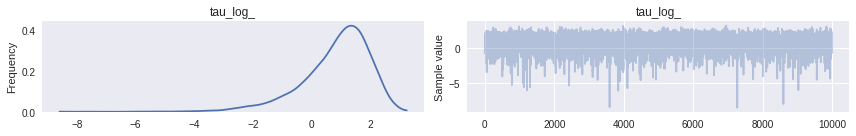

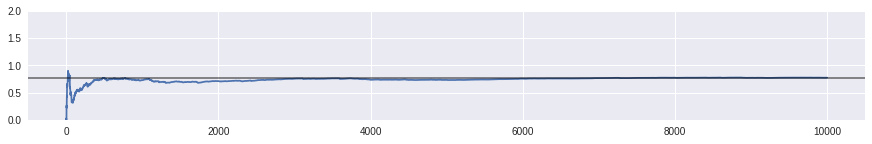

Number of Divergent 9
Percentage of Divergent 0.00090


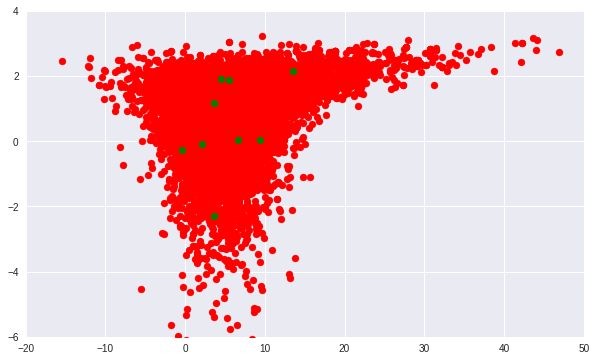

In [25]:
report_trace(fit_ncp80)

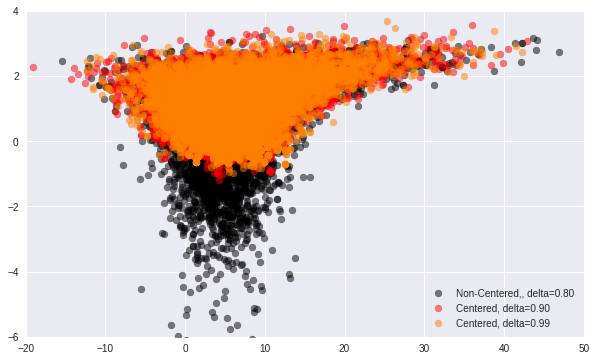

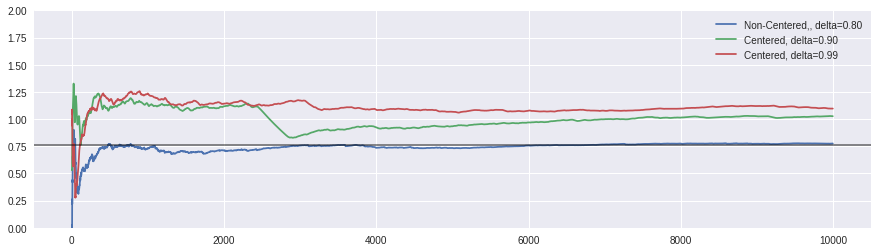

In [26]:
theta0 = fit_cp90['theta'][:,0]
logtau0  = fit_cp90['tau_log_']
divergent0 = fit_cp90['diverging']

theta1 = fit_cp99['theta'][:,0]
logtau1  = fit_cp99['tau_log_']
divergent1 = fit_cp99['diverging']

thetan = fit_ncp80['theta'][:,0]
logtaun  = fit_ncp80['tau_log_']
divergentn = fit_ncp80['diverging']

plt.figure(figsize=(10,6))
plt.scatter(thetan[divergentn==0],logtaun[divergentn==0],color='k',alpha=.5, label='Non-Centered,, delta=0.80')
plt.scatter(theta0[divergent0==0],logtau0[divergent0==0],color='r',alpha=.5, label='Centered, delta=0.90')
plt.scatter(theta1[divergent1==0],logtau1[divergent1==0],color=[1,0.5,0],alpha=.5, label='Centered, delta=0.99')
plt.axis([-20,50,-6,4])
plt.legend()
plt.show()

plt.figure(figsize=(15,4))
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1,len(logtaun))]
plt.plot(mlogtaun, label='Non-Centered,, delta=0.80')
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1,len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.90')
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1,len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99')
plt.axhline(0.7657852,color='k',alpha=.5)
plt.ylim(0,2)
plt.legend()
plt.show()